# Dark Matter Galactic Centre annihilation limits from CTA

Here we calculate the limits of the CTA telescope to dark matter annihilation from the galactic centre using the Equivalent Counts (EC) method which uses the Fisher Information matrix for experimental projections. The EC method is implemented through the swordfish package

In [50]:
from __future__ import division
import healpy as hp
import numpy as np
import HARPix as harp
import pylab as plt
import swordfish as sf
from tools import *
from scipy.interpolate import interp1d
from scipy.integrate import quad
from PPPC4DMID import interp
from math import cos, sin
from matplotlib import rc
import metricplot as mp

We now want to implement the dark matter signal as so,  

$$ \frac{dN}{d\Omega} = \frac{\langle \sigma v \rangle}{8 \pi m^2} \frac{dN}{dE} J\left(\Omega\right)$$

where $J(\Omega)$ is the astrophysical J factor and the rest of the expression represent the particle physics. We define the signal coming from the galactic centre with line of sight integrals through an NFW 

We now want to calculate the signal from the galactic halo in the form of a Jfactor map

In [13]:
def get_los():
    # Define DM profile
    MW_D = 8.5 # kpc
    MW_rs = 20 # kpc
    alpha = 0.17
    MW_rhoS = 0.122 # GeV cm^-3 (local density of 0.3 GeV/cm3)
    kpc_cm = 3.086e21 # kpc/cm
    def Lum_los(d, l, b):
        """Returns density squared for given galactic coordinates l and b at 
        distance d away from Suns location"""
        l = np.deg2rad(l)
        b = np.deg2rad(b)
        if (MW_D**2. + d**2. - (2*MW_D*d*cos(b)*cos(l))) < 0.0:
            R = 1e-5
        else:
            R = np.sqrt(MW_D**2. + d**2. - (2*MW_D*d*cos(b)*cos(l)))
        if R < 1e-5:
            R = 1e-5
        ratio = R/MW_rs
        rho_dm = MW_rhoS*np.exp(-(2/alpha)*((ratio)**alpha - 1))
        return rho_dm**2.
    l = np.logspace(-3,np.log10(180),num=50)
    los = np.zeros(len(l))
    for i in range(len(l)):
        los[i] = quad(Lum_los,0.,30.,args=(l[i],0.0))[0]*kpc_cm
    Interp_sig = interp1d(l,los)
    return Interp_sig

def get_Jmap():
    Interp_sig = get_los()
    #sig = harp.HARPix(dims=dims).add_singularity((0,0), 1, 20, n = 10)
    Jmap = harp.HARPix().add_disc((0,0), 5, 32)
    Jmap.add_func(lambda d: Interp_sig(d), mode = 'dist', center=(0,0))
    return Jmap

We now want to describe the main backgrounds which come from cosmic ray electrons and protons. The spectra of the electon and proton backgrounds are described as a broken power law and power law respectively. We take the values from 1408.4131.

In [14]:
def dNdE_e(E):
    """Cosmic-ray electron flux, 1/GeV cm2 s sr."""
    # TODO: Add reference
    E0 = 1e3
    return 1.17e-11*np.where(E > E0, (E/E0)**-3.9, (E/E0)**-3.0)

def dNdE_p(E):
    """Cosmic-ray proton flux, 1/GeV cm2 s sr."""
    # Factor of 3 accounts for approximate expected shift in energy
    # reconstruction, see Silverwood et al.
    return 8.73e-9*(E*3/1e3)**-2.71

def get_instr_bkg(E):
    """Crude estimation of instrumental background.  Return HARPix map."""
    CR_Elec_bkg = E.integrate(dNdE_e)
    proton_eff = 1e-2  # Assumed flat proton efficiency
    CR_Proton_bkg = proton_eff*E.integrate(dNdE_p)
    spec_bkg = CR_Proton_bkg + CR_Elec_bkg
    return harp.HARPix().add_iso(1, fill=1.).expand(spec_bkg)

Finally we need to define the spectrum of the signal component for which we will use a basic analytic approximation as,

$$ \frac{dN}{dE} \propto E^{-1.5}e^{-E/E_{cut}}$$

where we define the normalisation as,

$$ A\int dE\frac{dN}{dE}E = 2m_{DM}$$

In [51]:
#def get_sig_spec(sv, m, E):
#    Erange = np.logspace(1.0, 3.0, num=50)
#    def spec_DM(m, E):
#        spectrum = lambda x: x**(-1.5)*np.exp(-x/30.)
#        specnorm = lambda y: y*spectrum(y)
#        norm = 2*m/quad(specnorm,Erange[0],Erange[-1])[0]
#        return spectrum(E)*norm
#    return E.integrate(lambda x: sv/8/np.pi/m**2*spec_DM(m,x))
def get_sig_spec(sv, m, E, ch='bb'):
    spec_DM = interp.Interp(ch=ch)
    return E.integrate(lambda x: sv/8/np.pi/m**2*spec_DM(m,x))

We will also now define the exposure in terms of a HARPix map

In [52]:
def get_exposure(E, Tobs):
    """Generate exposure table, based on observation time.  Return HARPix map."""
    # Effective area taken from 
    # https://portal.cta-observatory.org/CTA_Observatory/performance/SiteAssets/SitePages/Home/PPP-South-EffectiveAreaNoDirectionCut.png
    Et, EffA = np.loadtxt("../data/CTA_effective_A.txt", unpack=True)
    Et *= 1e3  # TeV --> GeV
    EffA *= 1e4  # m2 --> cm2
    EffectiveA_cm2 = interp1d(Et, EffA, fill_value="extrapolate")(E.means)
    obsT = Tobs*3600  # h --> s
    expotab = obsT*EffectiveA_cm2  # Exposure in cm2 s  (Aeff * Tobs)
    return harp.HARPix().add_iso(1, fill = 1.).expand(expotab)

In [58]:
def CTA(m_DM, syst_flag = True, Tobs = 100.):
    # Parameters
    E = Logbins(1.0, 3.0, 50)   # GeV 10 GeV - 10 TeV
    unc = 0.01 # 1% bkg uncertainty
    corr_length = 1  # 10 deg correlation length of bkg uncertainty
    Sigma = get_sigma(E.means, lambda x, y: np.exp(-(x-y)**2/2/(x*y)/0.5**2))
    sv0 = 1e-26

    # Get J-value map
    J = get_Jmap()

    # Define signal spectrum
    t = sf.func_to_templates(lambda x, y: get_sig_spec(x*sv0, y, E), [1.,
       m_DM], dx = [.01,m_DM*0.01])

    # Get signal maps
    S = J.expand(t[0])
    dS = J.expand(t[1])

    # Get background (instr.)
    B = get_instr_bkg(E)  # FIXME?

    # Get exposure
    expo = get_exposure(E, Tobs)
    flux = [S,]
    fluxes, noise, systematics, exposure = get_model_input(flux, B,
            [dict(err = B*unc, sigma = corr_length, Sigma = Sigma, nside = 0)], expo)
    if not syst_flag: systematics = None
    m = sf.Swordfish(fluxes, noise, systematics, exposure, solver='direct', verbose = False)

    # Calculate upper limits with effective counts method
    ec = sf.EffectiveCounts(m)
    x_UL = ec.upperlimit(0.05, 0, gaussian = True)
    sv_UL = x_UL*sv0
    s, b = ec.effectivecounts(0, 1.)
    print "Total signal counts (theta = 1):", ec.counts(0, 1.0)
    print "Eff.  signal counts (theta = 1):", s
    print "Eff.  bkg counts (theta = 1)   :", b
    print "Upper limit on theta           :", sv_UL

    return sv_UL

Finally lets make a limit plot with streamlines to show the density of models in the paramter space

Total signal counts (theta = 1): 456.516379149
Eff.  signal counts (theta = 1): 55.6279325452
Eff.  bkg counts (theta = 1)   : 82316.8304176
Upper limit on theta           : 1.3616181361e-25
Mass [GeV] 31.6227766017
Upper limit [cm3/s]: 1.3616181361e-25
Total signal counts (theta = 1): 733.415305538
Eff.  signal counts (theta = 1): 81.5579988367
Eff.  bkg counts (theta = 1)   : 108267.539203
Upper limit on theta           : 1.06509046978e-25
Mass [GeV] 35.6224789026
Upper limit [cm3/s]: 1.06509046978e-25
Total signal counts (theta = 1): 1131.46387248
Eff.  signal counts (theta = 1): 117.082687715
Eff.  bkg counts (theta = 1)   : 145947.783354
Upper limit on theta           : 8.61410170581e-26
Mass [GeV] 40.1280703194
Upper limit [cm3/s]: 8.61410170581e-26
Total signal counts (theta = 1): 1685.3105218
Eff.  signal counts (theta = 1): 162.422309551
Eff.  bkg counts (theta = 1)   : 195476.691435
Upper limit on theta           : 7.18630648255e-26
Mass [GeV] 45.2035365636
Upper limit [cm3/s

Total signal counts (theta = 1): 44000.3764582
Eff.  signal counts (theta = 1): 19317.6413213
Eff.  bkg counts (theta = 1)   : 556548253.77
Upper limit on theta           : 3.22404608473e-26
Mass [GeV] 489.390091848
Upper limit [cm3/s]: 3.22404608473e-26
Total signal counts (theta = 1): 44727.5997604
Eff.  signal counts (theta = 1): 22149.0055043
Eff.  bkg counts (theta = 1)   : 749769690.514
Upper limit on theta           : 3.26372558364e-26
Mass [GeV] 551.288978877
Upper limit [cm3/s]: 3.26372558364e-26
Total signal counts (theta = 1): 44990.2257541
Eff.  signal counts (theta = 1): 24330.7867264
Eff.  bkg counts (theta = 1)   : 928418547.386
Upper limit on theta           : 3.30612811605e-26
Mass [GeV] 621.016941892
Upper limit [cm3/s]: 3.30612811605e-26
Total signal counts (theta = 1): 44811.6108945
Eff.  signal counts (theta = 1): 25414.2505401
Eff.  bkg counts (theta = 1)   : 1041466934.95
Upper limit on theta           : 3.35235006527e-26
Mass [GeV] 699.564215671
Upper limit [cm3

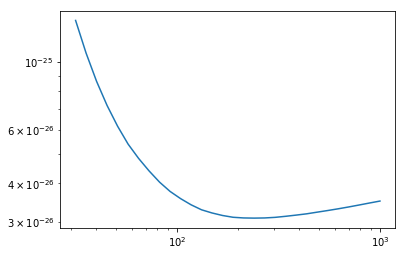

In [59]:
mlist = np.logspace(1.5, 3.0, 30)
svlist = np.logspace(-27, -24, 31)
ULlist = []
G = np.zeros((len(svlist), len(mlist),2,2))
for i, m in enumerate(mlist):
    UL = CTA(m, syst_flag = True)
    print "Mass [GeV]", m
    print "Upper limit [cm3/s]:", UL
    ULlist.append(UL)
    
plt.loglog(mlist,ULlist)
plt.show()